In [2]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [6]:
conn = pymysql.connect(
        host="192.168.7.93",
        user="quantchina",
        password="zMxq7VNYJljTFIQ8",
        database="wind",
        charset="gbk"
)
cursor = conn.cursor()

query = """
        select b.dt, a.S_INFO_WINDCODE, a.NET_PROFIT_INCL_MIN_INT_INC, a.NET_PROFIT_AFTER_DED_NR_LP 
        from (select REPORT_PERIOD, LAG(REPORT_PERIOD) OVER (ORDER BY S_INFO_WINDCODE, REPORT_PERIOD) pd,
                     S_INFO_WINDCODE, LAG(S_INFO_WINDCODE) OVER (ORDER BY S_INFO_WINDCODE, REPORT_PERIOD) pc, NET_PROFIT_INCL_MIN_INT_INC, NET_PROFIT_AFTER_DED_NR_LP 
              from ASHAREINCOME
              where ANN_DT between '20220101' and '20231231' and STATEMENT_TYPE=408001000) a 
        join (select distinct last_day(TRADE_DT) as dt, S_INFO_WINDCODE
              from ASHAREEODPRICES
              where TRADE_DT between '20220101' and '20231231') b
        on a.S_INFO_WINDCODE=b.S_INFO_WINDCODE and ((b.dt>a.pd and b.dt<=a.REPORT_PERIOD and a.S_INFO_WINDCODE=a.pc) or ((a.pc is null or a.S_INFO_WINDCODE!=a.pc) and b.dt<=a.REPORT_PERIOD))
        order by b.dt, a.S_INFO_WINDCODE
        """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['date', 'code', 'profit1', 'profit2'])
# df[['profit1', 'profit2']] = df[['profit1', 'profit2']].astype(float)
# df.dropna(subset=['profit1', 'profit2'], how='all', inplace=True)
# df['net_profit'] = np.nanmin(df[['profit1', 'profit2']], axis=1)

KeyboardInterrupt: 

In [9]:
cursor.close()
conn.close()

In [11]:
conn = pymysql.connect(
        host="192.168.7.93",
        user="quantchina",
        password="zMxq7VNYJljTFIQ8",
        database="wind",
        charset="gbk"
)
cursor = conn.cursor()
query = """
        select b.dt, a.S_INFO_WINDCODE, a.NET_PROFIT_INCL_MIN_INT_INC, a.NET_PROFIT_AFTER_DED_NR_LP 
        from (select ACTUAL_ANN_DT, LAG(ACTUAL_ANN_DT) OVER (ORDER BY S_INFO_WINDCODE, ACTUAL_ANN_DT)              pd, S_INFO_WINDCODE, LAG(S_INFO_WINDCODE) OVER (ORDER BY S_INFO_WINDCODE, ACTUAL_ANN_DT) pc, NET_PROFIT_INCL_MIN_INT_INC, NET_PROFIT_AFTER_DED_NR_LP 
              from ASHAREINCOME
              where ACTUAL_ANN_DT between '{start}' and '{end}' and STATEMENT_TYPE=408001000) a 
        join (select distinct last_day(TRADE_DT) as dt, S_INFO_WINDCODE
              from ASHAREEODPRICES
              where TRADE_DT between '{start}' and '{end}') b
        on a.S_INFO_WINDCODE=b.S_INFO_WINDCODE and ((b.dt>a.pd and b.dt<=a.ACTUAL_ANN_DT and a.S_INFO_WINDCODE=a.pc)  or ((a.pc is null or a.S_INFO_WINDCODE!=a.pc) and b.dt<=a.ACTUAL_ANN_DT))
        order by b.dt, a.S_INFO_WINDCODE
        """.format(start='20210101', end='20211231')
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['date', 'code', 'profit1', 'profit2'])

KeyboardInterrupt: 

In [12]:
conn = pymysql.connect(
        host="192.168.7.93",
        user="quantchina",
        password="zMxq7VNYJljTFIQ8",
        database="wind",
        charset="gbk"
)
cursor = conn.cursor()

query = """
        select b.dt, a.S_INFO_WINDCODE, a.S_FA_EPS_BASIC, a.S_FA_GROSSPROFITMARGIN, a.S_FA_NETPROFITMARGIN, a.S_FA_ROE, a.S_FA_ROA 
        from (select REPORT_PERIOD, LAG(REPORT_PERIOD) OVER (ORDER BY S_INFO_WINDCODE, REPORT_PERIOD) pd,
                     S_INFO_WINDCODE, LAG(S_INFO_WINDCODE) OVER (ORDER BY S_INFO_WINDCODE, REPORT_PERIOD) pc, S_FA_EPS_BASIC, S_FA_GROSSPROFITMARGIN,S_FA_NETPROFITMARGIN, S_FA_ROE, S_FA_ROA 
              from ASHAREFINANCIALINDICATOR
              where REPORT_PERIOD between '20220101' and '20221231') a 
        join (select distinct last_day(TRADE_DT) as dt, S_INFO_WINDCODE
              from ASHAREEODPRICES
              where TRADE_DT between '20220101' and '20221231') b
        on a.S_INFO_WINDCODE=b.S_INFO_WINDCODE and ((b.dt>a.pd and b.dt<=a.REPORT_PERIOD and a.S_INFO_WINDCODE=a.pc) or ((a.pc is null or a.S_INFO_WINDCODE!=a.pc) and b.dt<=a.REPORT_PERIOD))
        order by b.dt, a.S_INFO_WINDCODE
        """
cursor.execute(query)
data = cursor.fetchall()
dff = pd.DataFrame(data, columns=['date', 'code', 'eps', 'gross_margin', 'net_margin', 'roe', 'roa'])
dff.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

KeyboardInterrupt: 

In [2]:
def max_drawdown(cml_rets):
    """
    计算投资组合的最大回撤，最大回撤时长
    :param cml_rets: 组合的累计收益
    """
    n = len(cml_rets)
    res = 0
    before = temp = after = 0
    a = cml_rets[0]
    for i in range(1, n):
        b = cml_rets[i]
        if (1 - b / a) > res:
            res = 1 - b / a
            after = i
            before = temp
        if b > a:
            a = b
            temp = i
    return res, after - before


def neutralize(df, industry):
    """
    将因子对市值，行业中性化
    :params df:         各列依次为日期，股票代码，需要中性化的因子，市值
    :params industry:   含个股行业的数据框
    :return neutralize: 返回列表，中性化后的因子值
    """
    result = np.array([])
    # OLS取残差实现中性化处理
    for date in tqdm(df.date.unique(), desc="Processing"):
        scaler = StandardScaler()
        # 把日期列剔除，设置股票代码为行索引
        df_ols = (df[df.date == date]).iloc[:, 1:]
        ind_ols = (industry[industry.date == date]).iloc[:, 1:]
        df_ols.set_index('code', inplace=True)
        ind_ols.set_index('code', inplace=True)
        # 合并数据框，Z-Score标准化
        df_ols = pd.merge(df_ols, ind_ols, left_index=True, right_index=True, how='inner')
        df_ols['fac_vals'] = scaler.fit_transform(df_ols.fac_vals.to_numpy().reshape(-1, 1))
        df_ols['vals'] = scaler.fit_transform(df_ols.vals.to_numpy().reshape(-1, 1))
        # 对11个一级行业添加10个虚拟变量
        dummies = pd.get_dummies(df_ols.industry)
        dummies.drop(['6260'], axis=1, inplace=True)
        df_dummies = pd.concat([df_ols, dummies], axis=1)
        # 因子中性化
        y = df_dummies.fac_vals.to_numpy()
        X = sm.add_constant(df_dummies.drop(['fac_vals', 'industry'], axis=1).to_numpy())
        model = sm.OLS(y, X).fit()
        result = np.hstack((result, model.resid))

    return result


def group_divide(factor, daily_return, group=5):
    """分层后每层等权计算组合收益"""
    cml = (1 + daily_return).cumprod().T
    cml['fac'] = factor.mean().T
    cml['group'] = pd.qcut(cml['fac'], q=group, labels=range(1, group + 1))
    tmp = cml.groupby('group').mean().iloc[:, :-1]

    return tmp


def factor_group(factor, fac_all, returns, hist_ret, freq, group=5):
    """
    分层法测试单因子单调性
    :param factor:   当日指数成分股的因子值，有三列date, code, factor values
    :param fac_all:  所有在指数中出现过的股票的因子值，索引为date，列名为code，值为factor values
    :param returns:  当日指数个股的收益率，有三列date, code, daily return
    :param hist_ret: 所有在指数中出现过的股票的日收益率，索引为date，列名为code，值为daily return
    :param freq:     调仓频率
    :param group:    分组个数
    """
    trade_dt = returns.date.unique()
    labels = [i for i in range(1, group + 1)] + ['long_short']
    # 按分组和日期储存结果
    result = pd.DataFrame(1, index=labels, columns=[trade_dt[0]])

    # 每次获得一期的累计收益率，与上一期末的累积收益相乘，得到总的累计收益
    if freq == 'day':
        for i in range(len(trade_dt) - 1):
            codes = factor[factor.date == trade_dt[i]].code
            fac_df = pd.pivot_table(factor[factor.date == trade_dt[i]], values='fac_vals', index='date', columns='code')
            rets = hist_ret.loc[[trade_dt[i + 1]], codes]
            cml = rets.T
            cml['fac'] = fac_df.mean().T
            # 通过因子值分层计算组合收益
            cml['group'] = pd.qcut(cml['fac'], q=group, labels=range(1, group + 1))
            tmp = cml.groupby('group').mean().iloc[:, :-1]
            tmp = pd.DataFrame(tmp, index=range(1, group + 1))
            tmp.loc['long_short'] = tmp.loc[1] - tmp.loc[group]
            tmp = (1 + tmp).cumprod(axis=1)
            result = pd.concat([result, tmp.apply(lambda x: x * result.iloc[:, -1])], axis=1)

    else:
        dates = pd.to_datetime(trade_dt)
        # 获取每周或每月的第一个交易日
        adj_dt = get_adjust_dt(dates, freq)
        # 加入结束日期，得到日期区间的完整分割
        if adj_dt[-1] != trade_dt[-1]:
            adj_dt.append(trade_dt[-1])
        n = len(adj_dt)
        for i in range(n - 1):
            start, end = adj_dt[i], adj_dt[i + 1]
            codes = factor[factor.date == start].code
            fac_df = (fac_all.loc[start:end, codes])[:-1]  # 一期内的因子值
            rets = (hist_ret.loc[start:end, codes])[1:]  # 一期内的日收益率
            cml = (1 + rets).cumprod().T - 1
            cml['fac'] = fac_df.mean().T
            cml['group'] = pd.qcut(cml['fac'], q=group, labels=range(1, group + 1))
            tmp = cml.groupby('group').mean().iloc[:, :-1]
            tmp = pd.DataFrame(tmp, index=range(1, group + 1))
            tmp.loc['long_short'] = -tmp.loc[1] + tmp.loc[group]
            result = pd.concat([result, (1 + tmp).apply(lambda x: x * result.iloc[:, -1])], axis=1)

    return result


def plot_by_group(df_group):
    """画出不同层次的累计收益随时间变化图"""
    group = df_group.shape[0] - 1
    df_group.columns = pd.to_datetime(df_group.columns)
    for i in range(0, group):
        plt.plot(df_group.iloc[i, :], linewidth=1.5, alpha=0.8, label=str(i + 1))
    plt.plot(df_group.iloc[-1, :], linewidth=1.5, alpha=0.8, label='long short')

    plt.title('Daily Portfolio Value Over Time ')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('turnover grouped(17-23).pdf', format='pdf')
    plt.show()

In [3]:
# 读取数据
names = pd.read_parquet('names.parquet')
all_df = pd.read_parquet('factors(2017-2023).parquet')
ind = pd.read_parquet('industry(2017-2023).parquet')
hist_ret = pd.read_parquet('hist returns(17-23).parquet')

In [4]:
# 通过pandas合成数据
factors = pd.merge(names, all_df, on=['date', 'code'], how='left')
factors = factors.rename(columns={'turnover': 'fac_vals'})
returns = pd.merge(names, hist_ret, on=['date', 'code'], how='left')
hist_ret = pd.pivot_table(hist_ret, index='date', columns='code', values='pct_change')
all_factors = pd.pivot_table(all_df.drop(columns='vals'), index='date', columns='code', values='turnover')

In [6]:
# factor_df = factors.drop(columns='vals')
# factor_df['fac_vals'] = neutralize(factors, ind)
# factor_df.to_parquet('turnover neutral(17-23).parquet', index=False)
# 读取中性化后的因子值
# factor_df = pd.read_parquet('turnover neutral(17-23).parquet')

In [5]:
def get_adjust_dt(date_ls, freq):
    """
    根据给定的日期区间和频率获取选股日期，即每月或每周的最后一个交易日
    :param date_ls: 一段时间内的所有交易日
    :param freq:    调仓频率
    """
    result = []
    if freq == 'day':
        result = date_ls

    if freq == 'week':
        for i in range(1, len(date_ls)):  
            if date_ls[i].weekday() <= date_ls[i - 1].weekday():
                result.append(date_ls[i])

    if freq == 'month':
        for i in range(1, len(date_ls)):
            if date_ls[i].month != date_ls[i - 1].month:
                result.append(date_ls[i])

    result = [datetime.strftime(date, '%Y%m%d') for date in result]
    return result


def get_choose_dt(date_ls, freq):
    """
    根据给定的日期区间和频率获取选股日期，即每月或每周的最后一个交易日
    :param date_ls: 一段时间内的所有交易日
    :param freq:    调仓频率
    """
    result = []
    if freq == 'day':
        result = date_ls

    if freq == 'week':
        for i in range(len(date_ls) - 1):  
            if date_ls[i].weekday() >= date_ls[i + 1].weekday():
                result.append(date_ls[i])

    if freq == 'month':
        for i in range(len(date_ls) - 1):
            if date_ls[i].month != date_ls[i + 1].month:
                result.append(date_ls[i])

    result = [datetime.strftime(date, '%Y%m%d') for date in result]
    return result

In [6]:
factor_df = pd.read_parquet('turnover_all neutral(17-23).parquet')
trade_dt = returns.date.unique()
dates = pd.to_datetime(trade_dt)
# 获取选股日期
adj_dt = get_adjust_dt(dates, 'week')
cho_dt = get_choose_dt(dates, 'week')
# 加入结束日期，得到日期区间的完整分割
adj_dt.insert(0, trade_dt[0])
if cho_dt[-1] != trade_dt[-1]:
    cho_dt.append(trade_dt[-1])

In [7]:
len(adj_dt), len(cho_dt)

(351, 351)

In [8]:
# 根据上期因子的平均值选股
labels = [i for i in range(1, 6)] + ['long_short']
# 按分组和日期储存结果
result_mean = pd.DataFrame(1, index=labels, columns=[cho_dt[0]])

n = len(adj_dt)
# 每次获得一期的累计收益率，与上一期末的累积收益相乘，得到总的累计收益
for i in tqdm(range(n - 1), desc="Processing"):
    start1, end1 = adj_dt[i], cho_dt[i]
    start2, end2 = adj_dt[i + 1], cho_dt[i + 1]
    codes = names[names.date == end1].code     # 上期末进行选股
    fac_df = factor_df.loc[start1:end1, codes] # 上期的因子值
    rets = hist_ret.loc[start2:end2, codes]    # 当期的日收益率
    cml = (1 + rets).cumprod().T - 1
    cml['fac'] = fac_df.mean()
    # 通过因子值分层计算组合收益
    cml['group'] = pd.qcut(cml['fac'], q=5, labels=range(1, 6))
    tmp = cml.groupby('group').mean().iloc[:, :-1]
    tmp = pd.DataFrame(tmp, index=range(1, 6))
    tmp.loc['long_short'] = tmp.loc[1] - tmp.loc[5]
    result_mean = pd.concat([result_mean, (1 + tmp).apply(lambda x: x * result_mean.iloc[:, -1])], axis=1)

Processing: 100%|██████████| 350/350 [01:51<00:00,  3.13it/s]


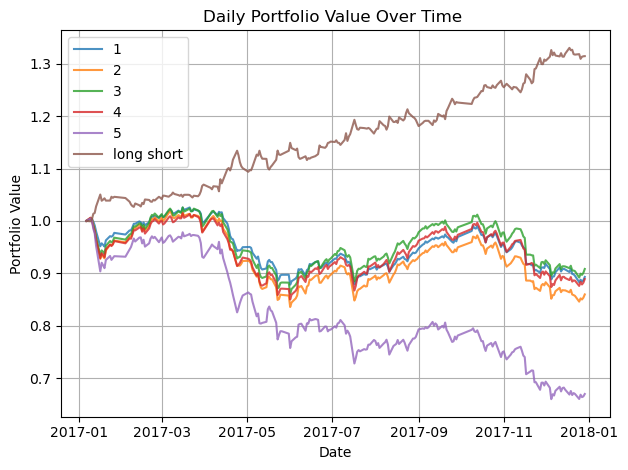

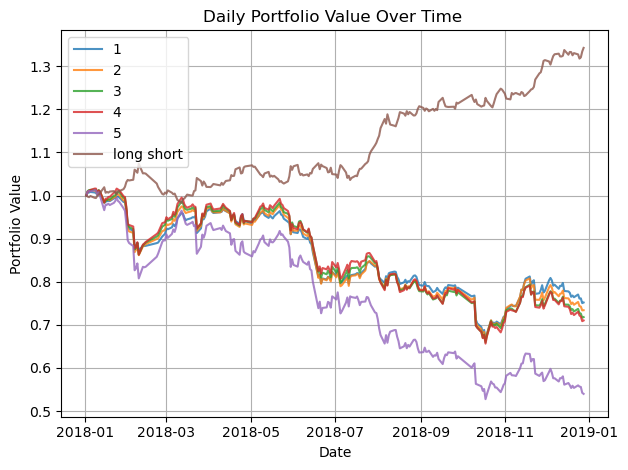

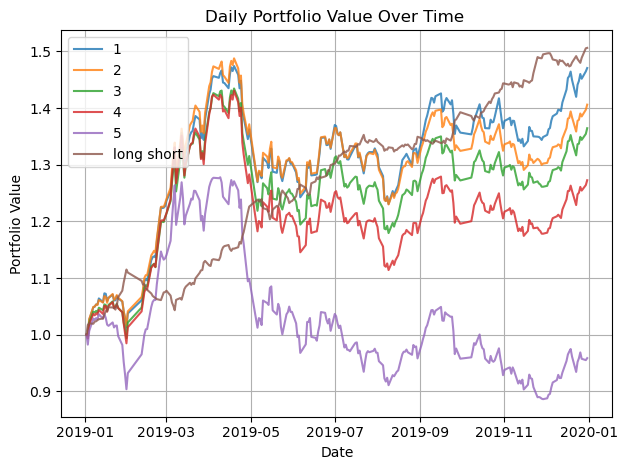

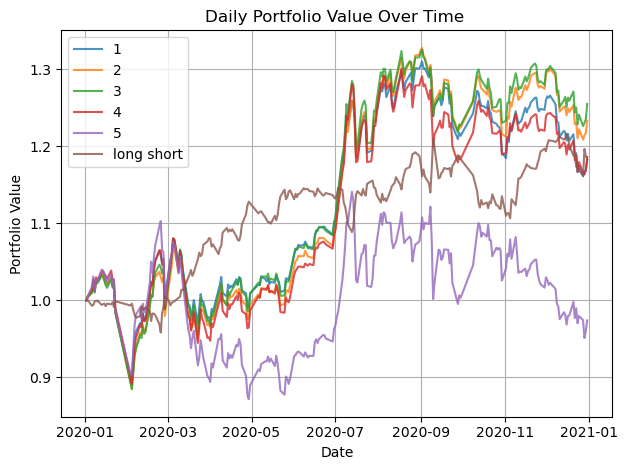

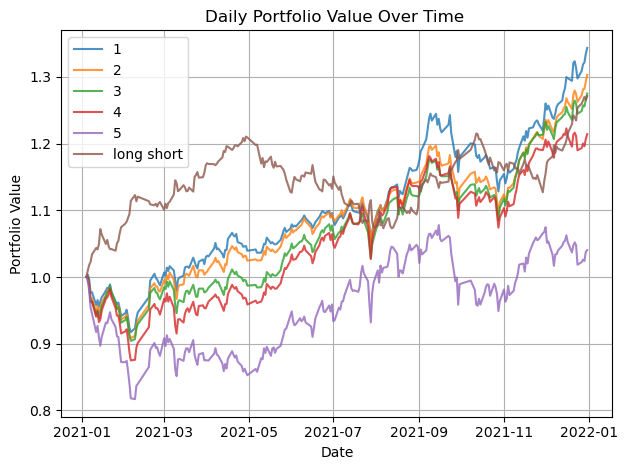

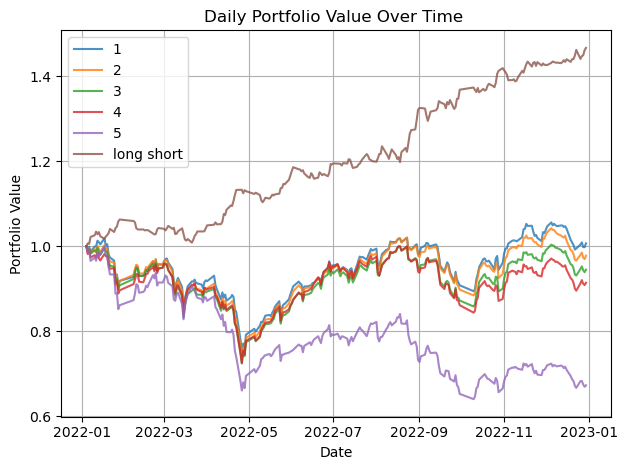

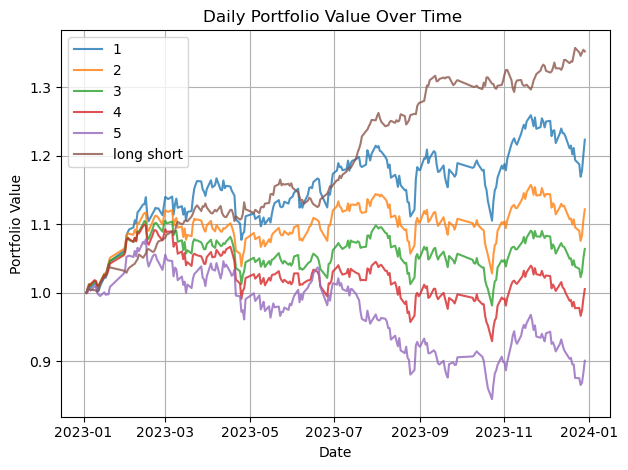

In [10]:
result_mean.columns = pd.to_datetime(result_mean.columns)
years = range(2017, 2024)
for year in years:
    df_year = result_mean.loc[:, result_mean.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    for i in range(0, 5):
        plt.plot(df_year.iloc[i, :], linewidth=1.5, alpha=0.8, label=str(i + 1))
    plt.plot(df_year.iloc[-1, :], linewidth=1.5, alpha=0.8, label='long short')
    
    plt.title('Daily Portfolio Value Over Time ')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
years = range(2017, 2024)
for year in years:
    df_year = result_mean.loc[:, result_mean.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    
    legends = [i for i in range(1, 6)] + ['long_short']
    daily_return = (df_year / df_year.shift(1, axis=1) - 1).dropna(axis=1)
    summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
    summary['return'] = df_year.iloc[:, -1] - 1
    summary['volatility'] = daily_return.std(axis=1)
    summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
    summary.loc[:, ['drawdown', 'drawdown_time']] = np.array(df_year.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
    print(year)
    print(summary)

In [ ]:
legends = [i for i in range(1, 6)] + ['long_short']
daily_return = (result_mean / result_mean.shift(1, axis=1) - 1).dropna(axis=1)
summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
summary['return'] = result_mean.iloc[:, -1] - 1
summary['volatility'] = daily_return.std(axis=1)
summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
summary.loc[:, ['drawdown', 'drawdown_time']] = np.array(result_mean.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
print(summary)

In [20]:
# 更改调仓频率，只看期末的换手率
factor_df = pd.read_parquet('turnover_all neutral(17-23).parquet')
trade_dt = returns.date.unique()
dates = pd.to_datetime(trade_dt)
# 获取选股日期
adj_dt = get_adjust_dt(dates, 'week')
cho_dt = get_choose_dt(dates, 'week')
# 加入结束日期，得到日期区间的完整分割
adj_dt.insert(0, trade_dt[0])
if cho_dt[-1] != trade_dt[-1]:
    cho_dt.append(trade_dt[-1])

labels = [i for i in range(1, 6)] + ['long_short']
# 按分组和日期储存结果
result = pd.DataFrame(1, index=labels, columns=[trade_dt[0]])

n = len(adj_dt)
for i in tqdm(range(n - 1), desc="Processing"):
    xuangu = cho_dt[i]
    start, end = adj_dt[i + 1], cho_dt[i + 1]
    codes = names[names.date == xuangu].code
    fac_df = factor_df.loc[xuangu, codes]   # 上期的因子值
    rets = hist_ret.loc[start:end, codes]   # 当期的日收益率
    cml = (1 + rets).cumprod().T - 1
    cml['fac'] = fac_df.T
    # 通过因子值分层计算组合收益
    cml['group'] = pd.qcut(cml['fac'], q=5, labels=range(1, 6))
    tmp = cml.groupby('group').mean().iloc[:, :-1]
    tmp = pd.DataFrame(tmp, index=range(1, 6))
    tmp.loc['long_short'] = tmp.loc[1] - tmp.loc[5]
    result = pd.concat([result, (1 + tmp).apply(lambda x: x * result.iloc[:, -1])], axis=1)

Processing: 100%|██████████| 350/350 [01:51<00:00,  3.13it/s]


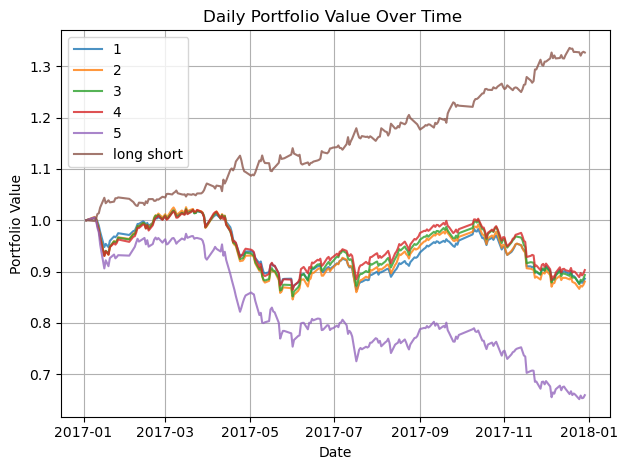

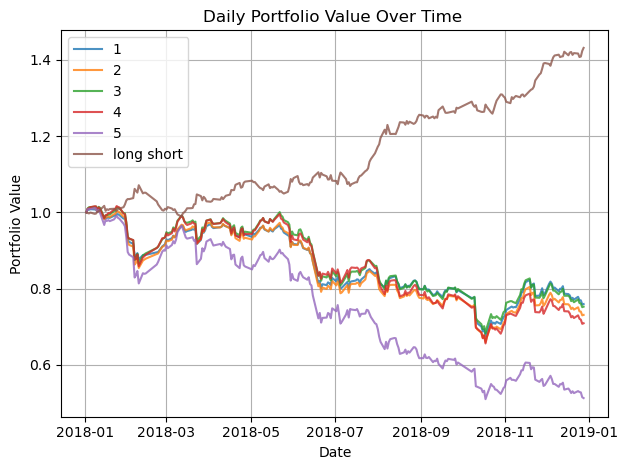

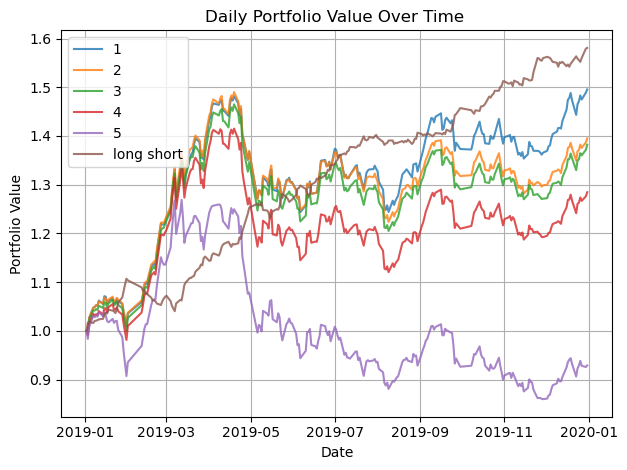

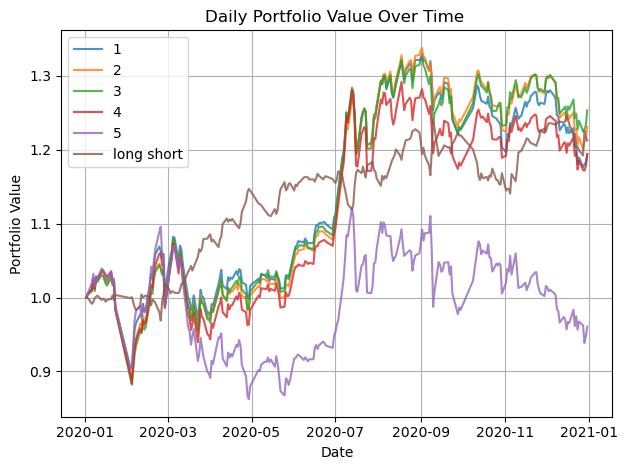

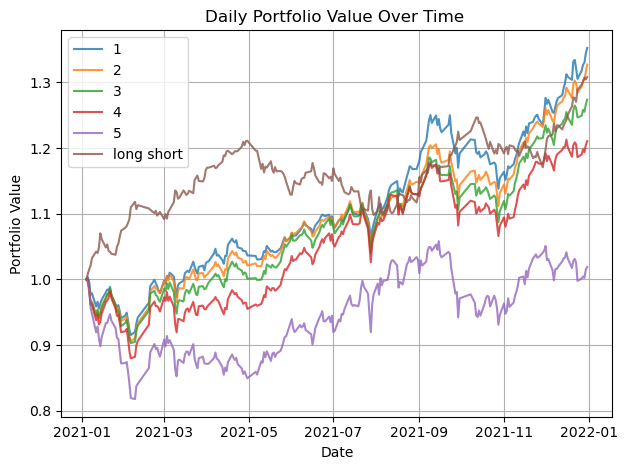

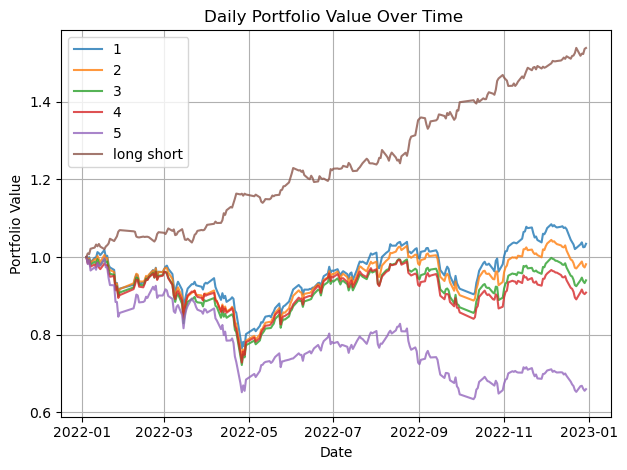

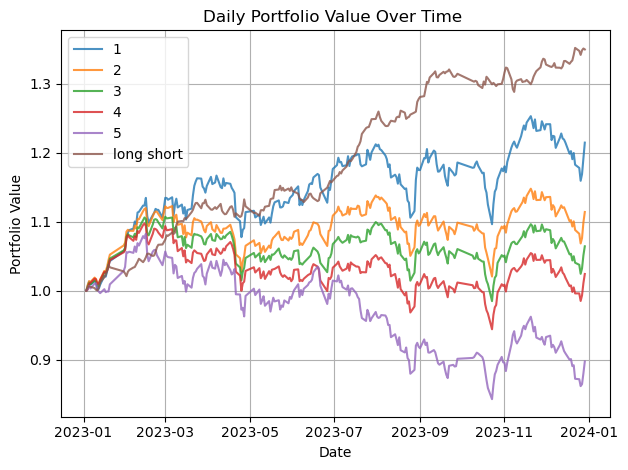

In [21]:
result.columns = pd.to_datetime(result.columns)
years = range(2017, 2024)
for year in years:
    df_year = result.loc[:, result.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    for i in range(0, 5):
        plt.plot(df_year.iloc[i, :], linewidth=1.5, alpha=0.8, label=str(i + 1))
    plt.plot(df_year.iloc[-1, :], linewidth=1.5, alpha=0.8, label='long short')
    
    plt.title('Daily Portfolio Value Over Time ')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.savefig(f'turnover grouped {year}.png', format='png')
    plt.tight_layout()
    plt.show()

In [17]:
years = range(2017, 2024)
for year in years:
    df_year = result.loc[:, result.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    
    legends = [i for i in range(1, 6)] + ['long_short']
    daily_return = (df_year / df_year.shift(1, axis=1) - 1).dropna(axis=1)
    summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
    summary['return'] = df_year.iloc[:, -1] - 1
    summary['volatility'] = daily_return.std(axis=1)
    summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
    summary.loc[:, ['drawdown', 'drawdown_time']] = np.array(df_year.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
    print(year)
    print(summary)

2017
              return  volatility    sharpe  drawdown  drawdown_time
1          -0.127857    0.008295 -1.092017  0.172281          192.0
2          -0.097431    0.009632 -0.670596  0.174224           50.0
3          -0.079730    0.009341 -0.550283  0.161429           50.0
4          -0.070369    0.009376 -0.471931  0.152031           50.0
5          -0.243248    0.012302 -1.492119  0.293105          192.0
long_short  0.142774    0.005090  1.882502  0.030298            5.0
2018
              return  volatility    sharpe  drawdown  drawdown_time
1          -0.292742    0.013774 -1.538059  0.369351          184.0
2          -0.288824    0.015038 -1.365089  0.362892          188.0
3          -0.288544    0.015290 -1.337202  0.351249          187.0
4          -0.292988    0.015939 -1.298425  0.350486          186.0
5          -0.424433    0.018985 -1.754546  0.454484          187.0
long_short  0.212931    0.006734  1.934201  0.062708           16.0
2019
              return  volatility 

In [22]:
legends = [i for i in range(1, 6)] + ['long_short']
daily_return = (result / result.shift(1, axis=1) - 1).dropna(axis=1)
summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
summary['return'] = result.iloc[:, -1] - 1
summary['volatility'] = daily_return.std(axis=1)
summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
summary.loc[:, ['drawdown', 'drawdown_time']] = np.array(result.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
print(summary)

              return  volatility    sharpe  drawdown  drawdown_time
1           1.202216    0.012407  0.694542  0.409180          388.0
2           0.726721    0.012764  0.502533  0.428402          388.0
3           0.576688    0.012953  0.432488  0.396937          388.0
4           0.171987    0.013504  0.217910  0.413891          385.0
5          -0.799399    0.016175 -0.799207  0.812660         1647.0
long_short  8.666815    0.006748  3.200522  0.093189           61.0


In [14]:
grouped = factor_group(factor_df, all_factors, returns, hist_ret, 'day', 5)

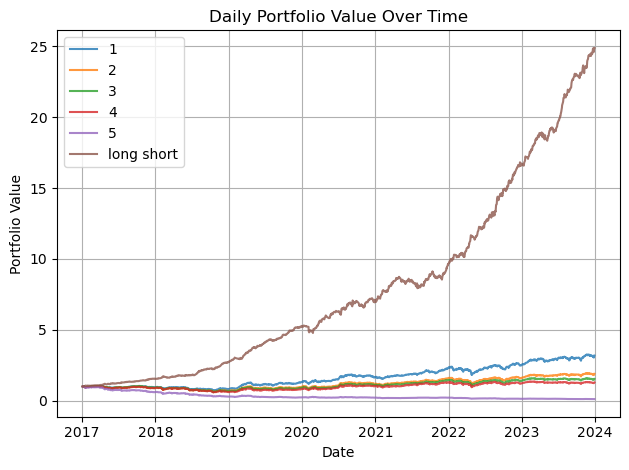

In [15]:
group = grouped.shape[0] - 1
grouped.columns = pd.to_datetime(grouped.columns)

for i in range(0, group):
    plt.plot(grouped.iloc[i, :], linewidth=1.5, alpha=0.8, label=str(i + 1))
plt.plot(grouped.iloc[-1, :], linewidth=1.5, alpha=0.8, label='long short')

plt.title('Daily Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('turnover grouped(17-23).png', format='png')
plt.show()

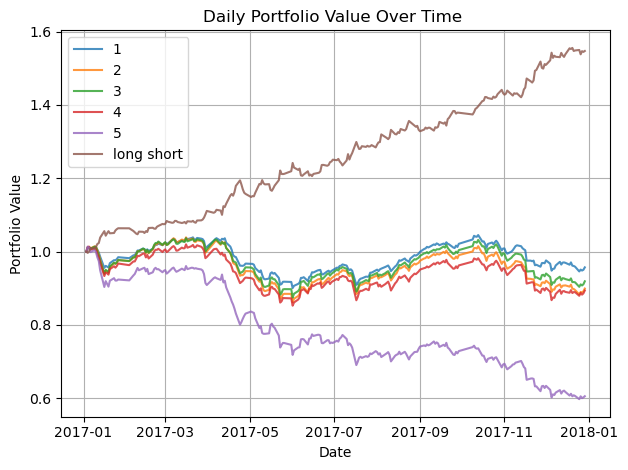

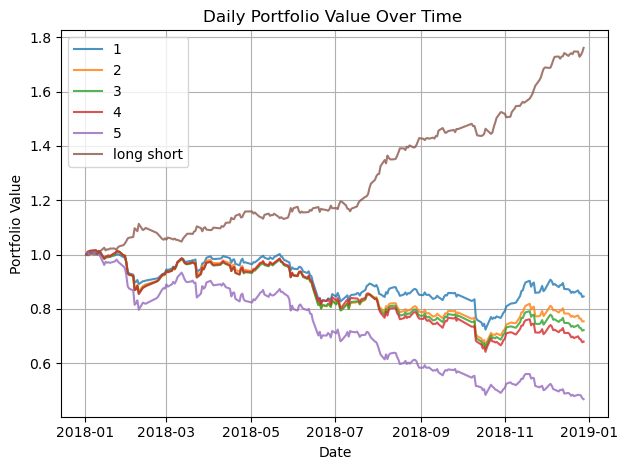

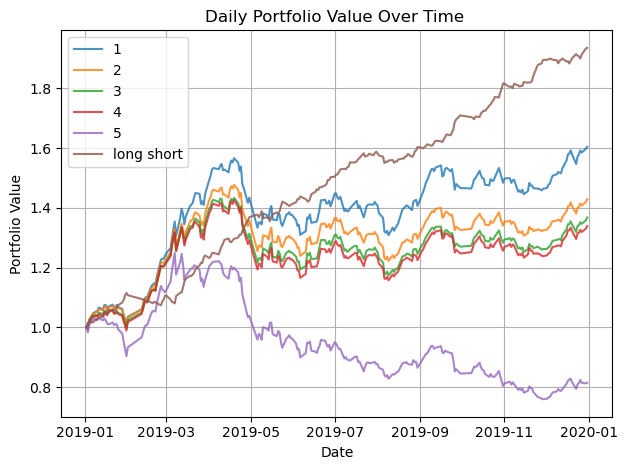

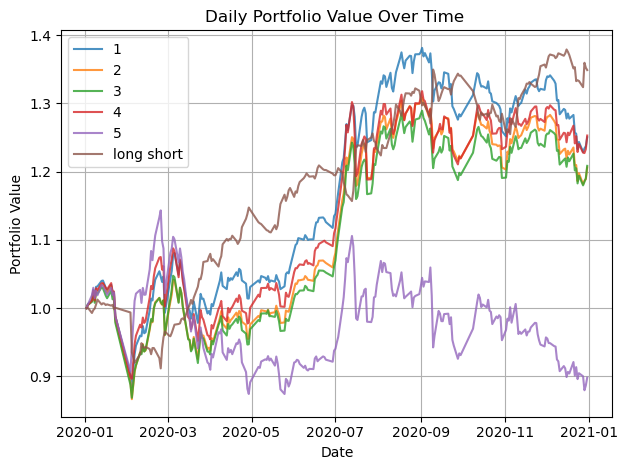

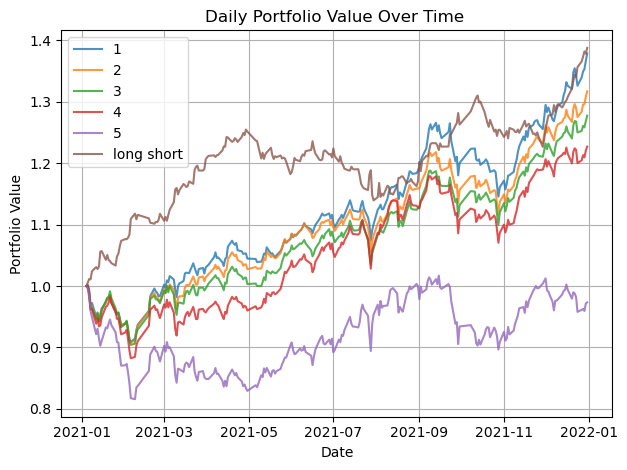

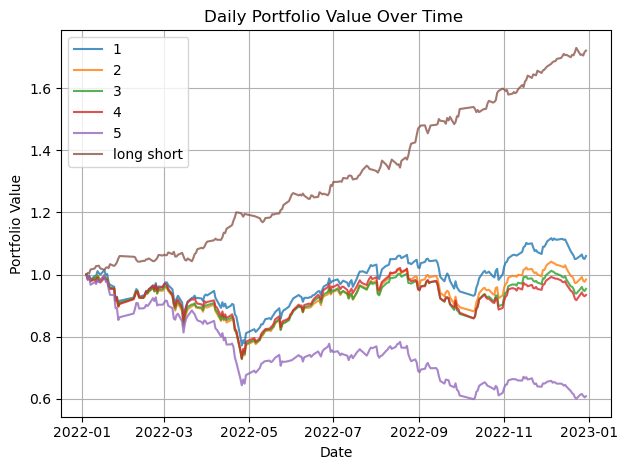

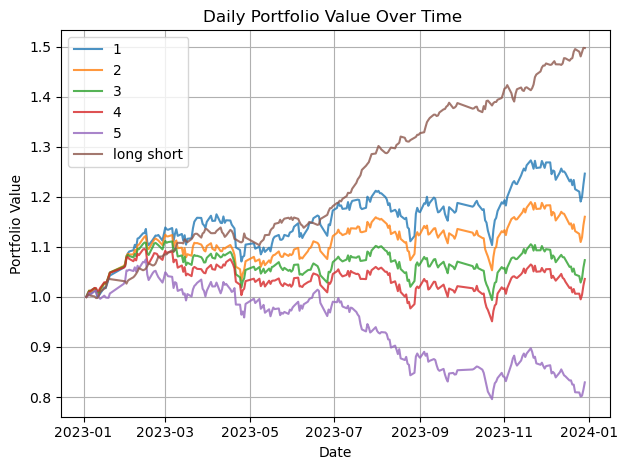

In [16]:
years = range(2017, 2024)
for year in years:
    df_year = grouped.loc[:, grouped.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    for i in range(0, group):
        plt.plot(df_year.iloc[i, :], linewidth=1.5, alpha=0.8, label=str(i + 1))
    plt.plot(df_year.iloc[-1, :], linewidth=1.5, alpha=0.8, label='long short')
    
    plt.title('Daily Portfolio Value Over Time ')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f'turnover grouped {year}.png', format='png')
    plt.show()

In [17]:
years = range(2017, 2024)
for year in years:
    df_year = grouped.loc[:, grouped.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    
    legends = [i for i in range(1, 6)] + ['long_short']
    daily_return = (df_year / df_year.shift(1, axis=1) - 1).dropna(axis=1)
    summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
    summary['return'] = df_year.iloc[:, -1] - 1
    summary['volatility'] = daily_return.std(axis=1)
    summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
    summary.loc[:, ['drawdown', 'drawdown_time']] = np.array(df_year.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
    print(year)
    print(summary)

2017
              return  volatility    sharpe  drawdown  drawdown_time
1          -0.042898    0.007731 -0.308856  0.133144           47.0
2          -0.100681    0.009821 -0.627343  0.170123           50.0
3          -0.080865    0.009672 -0.492352  0.156021           50.0
4          -0.105953    0.010013 -0.650665  0.164035           50.0
5          -0.394290    0.013333 -2.347266  0.410405          238.0
long_short  0.547280    0.006831  4.231765  0.038091            5.0
2018
              return  volatility    sharpe  drawdown  drawdown_time
1          -0.153861    0.014072 -0.665669  0.283370          184.0
2          -0.245412    0.015209 -1.091755  0.341205          188.0
3          -0.277735    0.015764 -1.226628  0.355284          186.0
4          -0.320120    0.016095 -1.442627  0.368093          186.0
5          -0.531898    0.018575 -2.528050  0.536332          240.0
long_short  0.760560    0.007499  5.013008  0.058499           16.0
2019
              return  volatility 

In [18]:
legends = [i for i in range(1, 6)] + ['long_short']
daily_return = (grouped / grouped.shift(1, axis=1) - 1).dropna(axis=1)
summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
summary['return'] = grouped.iloc[:, -1] - 1
summary['volatility'] = daily_return.std(axis=1)
summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
summary.loc[:, ['drawdown', 'drawdown_time']] = np.array(grouped.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
print(summary)

               return  volatility    sharpe  drawdown  drawdown_time
1            2.185467    0.012539  0.963363  0.332530          247.0
2            0.891650    0.012913  0.564428  0.417029          388.0
3            0.531034    0.013027  0.409587  0.412833          388.0
4            0.285047    0.013539  0.281214  0.432172          388.0
5           -0.887971    0.016043 -1.145014  0.893957         1650.0
long_short  23.894611    0.007131  4.270045  0.099599           26.0


In [29]:
# 创建示例数据框
data = {'A': [2, 7, 1, 4, 9],
        'B': [5, 2, 6, 1, 3],
        'C': [3, 6, 2, 5, 1]}
df = pd.DataFrame(data)

# 计算数据框中每个元素的排名
print(df)

   A  B  C
0  2  5  3
1  7  2  6
2  1  6  2
3  4  1  5
4  9  3  1
